https://academic.oup.com/jrsssa/article/187/2/513/7512935?utm_source=chatgpt.com&login=false

In [1]:
import pandas as pd
import numpy as np
import os
from patsy import dmatrix
import pymc as pm
import arviz as az
from sklearn.metrics import log_loss, brier_score_loss
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import pymc as pm
import pytensor.tensor as pt
import arviz as az
import pytensor
from pymc.distributions.transforms import ordered as ordered_tr
import numpy as np
import pymc as pm
from pymc.distributions.transforms import ordered as ordered_tr
from scipy.stats import norm
import arviz as az

# C backend yerine saf Python kullanmak için FAST_COMPILE
pytensor.config.mode = "FAST_COMPILE"
pytensor.config.cxx = ""  # C derleyici kullanma


In [2]:
# main.ipynb dosyasının bulunduğu klasörü bul
notebook_dir = os.path.dirname(os.path.abspath("__file__"))

# Bu çalışmayı Jupyter içinde yapıyorsan "__file__" çalışmaz, o yüzden fallback:
if notebook_dir == os.path.abspath("__file__"):
    notebook_dir = os.getcwd()

data_path = os.path.join(notebook_dir, "data", "full_df.csv")

try:
    df_raw = pd.read_csv(data_path)
    print("Veri başarıyla yüklendi! Satır sayısı:", len(df_raw))
except Exception as e:
    print("Veri yükleme hatası:", e)
    raise

Veri başarıyla yüklendi! Satır sayısı: 651633


In [3]:
if df_raw["timestamp"].dtype == object:
    # Bazı veri setleri '0 days 00:00:02.758649' string; bunu timedelta'a çevir
    def parse_td(x):
        try:
            return pd.to_timedelta(x)
        except:
            # bazen '00:00:02' formatı
            try:
                return pd.to_timedelta(x + " days")
            except:
                return pd.NaT
    df_raw["timestamp"] = df_raw["timestamp"].apply(parse_td)

In [4]:
# period_id 1 -> 0..45, period_id 2 -> 45..90
df = df_raw.copy()
# seconds
df["seconds"] = df["timestamp"].dt.total_seconds().fillna(0.0)
df["minute"] = (df["seconds"] // 60).astype(int)
# add 45 if second half
df["minute"] = df.apply(lambda r: int(r["minute"]) if r.get("period_id", 1) == 1 else int(r["minute"]) + 45, axis=1)

# clamp minute between 0 and 95
df["minute"] = df["minute"].clip(lower=0, upper=95)

In [5]:
cols = df.columns.tolist()
def safe_col(name):
    return name if name in cols else None

has = {c: (c in cols) for c in ["shot_action_id","xG","xT_value","VAEP","event_type","result","is_home","home_elo","away_elo","match_result","matchId","team_id"]}

# shot_action_id varsa numeriğe çevir (hatalıları NaN yap)
if "shot_action_id" in df.columns:
    df["shot_action_id"] = pd.to_numeric(df["shot_action_id"], errors="coerce")

agg_funcs = {}
# shots (varsa shot_action_id>0 olarak kabul)
if has["shot_action_id"]:
    agg_funcs["shots"] = ("shot_action_id", lambda x: (x.fillna(0) > 0).sum())
else:
    agg_funcs["shots"] = ("event_type", lambda x: (x == "SHOT").sum())

agg_funcs["passes"] = ("event_type", lambda x: (x == "PASS").sum() if has["event_type"] else 0)
agg_funcs["completed_passes"] = ("result", lambda x: (x == "COMPLETE").sum() if has["result"] else 0)
if has["xG"]:
    agg_funcs["xg_sum"] = ("xG", lambda x: x.fillna(0).sum())
if has["xT_value"]:
    agg_funcs["xt_sum"] = ("xT_value", lambda x: x.fillna(0).sum())
if has["VAEP"]:
    agg_funcs["vaep_sum"] = ("VAEP", lambda x: x.fillna(0).sum())

group_cols = []
# matchId may be named differently in dataset: we assume 'matchId' exists as in example
match_col = "matchId" if "matchId" in cols else ("match_id" if "match_id" in cols else None)
if match_col is None:
    raise ValueError("matchId veya match_id sütunu bulunamadı; veride maç id'si gerekli.")
group_cols = [match_col, "minute", "team_id"]

# aggregate
agg = df.groupby(group_cols).agg(**agg_funcs).reset_index()

In [6]:
# ---------------------------
# 4. HOME vs AWAY tek satıra indirme
# ---------------------------
# ensure is_home exists per team per match: if not, infer by comparing team_id to home_team/away_team mapping
if "is_home" not in df.columns:
    # try to infer using home_team/away_team columns (if team_name present)
    # else assume team with lower id is home (fallback) -- user may need to adapt this.
    if "home_team" in df.columns and "team_id" in df.columns:
        # build mapping per match: find first occurrence of home_team name mapping to team_id
        # This is heuristic — ideal: dataset contains is_home.
        map_home = {}
        for _, r in df.iterrows():
            if "home_team" in r and r["home_team"] and pd.notna(r["home_team"]) and r["team_name"]==r["home_team"]:
                map_home.setdefault((r[match_col]), set()).add(r["team_id"])
        # We'll apply later; but simplest: if mapping not reliable, require is_home in original data.
        pass

# extract home/away per match by looking at original df rows where is_home==True if exists
if "is_home" in df.columns:
    # join is_home to agg
    agg = agg.merge(df[[match_col,"team_id","is_home"]].drop_duplicates(), on=[match_col,"team_id"], how="left")
else:
    # fallback: try to infer using team_name/home_team columns in original df:
    if "team_name" in df.columns and "home_team" in df.columns:
        # take first row per match to get the mapping
        firsts = df[[match_col,"team_name","home_team"]].drop_duplicates()
        mapping = {}
        for _,r in firsts.iterrows():
            if pd.notna(r["home_team"]) and r["team_name"]==r["home_team"]:
                mapping.setdefault(r[match_col], set()).add(r["team_name"])
        # This is messy; prefer dataset with is_home.
        agg["is_home"] = np.nan
    else:
        agg["is_home"] = np.nan

# reshape to single row per matchId-minute (home & away cols)
# we need to know which rows are home vs away. If is_home is NaN for all, try to infer from unique teams per match
if agg["is_home"].isna().all():
    # assume two teams per match; pick the team with the smaller team_id as home (RISKY fallback)
    def infer_home_away(sub):
        teams = sub["team_id"].unique()
        if len(teams) >= 2:
            hm, aw = sorted(teams)[:2]
        else:
            hm = teams[0]
            aw = teams[0]
        return hm, aw
    rows = []
    for match, g in agg.groupby(match_col):
        hm, aw = infer_home_away(g)
        sub = g.copy()
        sub["is_home"] = sub["team_id"].apply(lambda t: True if t==hm else False)
        rows.append(sub)
    agg = pd.concat(rows, ignore_index=True)

# Now pivot: create home_* and away_* columns
home = agg[agg["is_home"]==True].copy()
away = agg[agg["is_home"]==False].copy()

# rename home/away features
def rename_prefix(df_in, prefix):
    df = df_in.copy()
    for c in ["shots","passes","completed_passes","xg_sum","xt_sum","vaep_sum"]:
        if c in df.columns:
            df.rename(columns={c: f"{prefix}_{c}"}, inplace=True)
    return df

home_r = rename_prefix(home, "home")
away_r = rename_prefix(away, "away")

merged = pd.merge(
    home_r[[match_col,"minute","team_id"] + [c for c in home_r.columns if c.startswith("home_")]],
    away_r[[match_col,"minute","team_id"] + [c for c in away_r.columns if c.startswith("away_")]],
    on=[match_col,"minute"],
    how="outer",
    suffixes=("_home","_away")
)

# fill NaN with zeros
merged.fillna(0, inplace=True)

In [7]:
# ---------------------------
# 5. DIFF FEATURES (home - away)
# ---------------------------
def safe_col_val(df, col):
    return df[col] if col in df.columns else 0

merged["shot_diff"] = merged.get("home_shots",0) - merged.get("away_shots",0)
merged["xg_diff"] = merged.get("home_xg_sum",0) - merged.get("away_xg_sum",0)
merged["xt_diff"] = merged.get("home_xt_sum",0) - merged.get("away_xt_sum",0)
merged["vaep_diff"] = merged.get("home_vaep_sum",0) - merged.get("away_vaep_sum",0)
# pass completion difference (safe)
hp = merged.get("home_completed_passes",0)
ht = merged.get("home_passes",0).replace(0, np.nan) if hasattr(merged.get("home_passes",0),"replace") else merged.get("home_passes",0)
ap = merged.get("away_completed_passes",0)
at = merged.get("away_passes",0).replace(0, np.nan) if hasattr(merged.get("away_passes",0),"replace") else merged.get("away_passes",0)
# fallback numeric compute:
merged["home_pass_comp_pct"] = np.where(merged.get("home_passes",0)>0, merged.get("home_completed_passes",0)/merged.get("home_passes",0), 0)
merged["away_pass_comp_pct"] = np.where(merged.get("away_passes",0)>0, merged.get("away_completed_passes",0)/merged.get("away_passes",0), 0)
merged["pass_comp_pct_diff"] = merged["home_pass_comp_pct"] - merged["away_pass_comp_pct"]

# attach match-level static features (home_elo, away_elo, match_result) from original df (first row per match)
match_info = df.sort_values(by=["seconds"]).groupby(match_col).first().reset_index()
static_cols = {}
if "home_elo" in match_info.columns and "away_elo" in match_info.columns:
    merged = merged.merge(match_info[[match_col,"home_elo","away_elo","match_result"]], on=match_col, how="left")
else:
    # Try find columns in original raw df with similar names
    for c in ["home_elo","away_elo","match_result"]:
        if c in df.columns:
            merged = merged.merge(df[[match_col,c]].drop_duplicates(), on=match_col, how="left")

# encode ordinal target: 0 away win, 1 draw, 2 home win
def encode_result(r):
    if pd.isna(r): return np.nan
    if str(r).upper().startswith("A"): return 0
    if str(r).upper().startswith("D") or str(r).upper().startswith("DRAW"): return 1
    if str(r).upper().startswith("H"): return 2
    # try numeric (some datasets use 1/0)
    try:
        rv = int(r)
        return rv
    except:
        return np.nan

if "match_result" in merged.columns:
    merged["y"] = merged["match_result"].apply(encode_result)
else:
    # fallback: construct y from home_score, away_score if present in match_info
    if "home_team" in match_info.columns and "away_team" in match_info.columns:
        merged["y"] = np.nan
    else:
        merged["y"] = np.nan

# Drop rows without target if you will train supervised (or forward-fill match result across minutes)
merged["y"] = merged["y"].fillna(method="ffill").fillna(method="bfill")
merged = merged.dropna(subset=["y"])

# time normalization
merged["t_norm"] = merged["minute"] / 90.0

C:\Users\Megad\AppData\Local\Temp\ipykernel_27932\3798957670.py:55: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged["y"] = merged["y"].fillna(method="ffill").fillna(method="bfill")


In [8]:
# ---------------------------
# 6. MODELLER İÇİN TASARIM MATRİSİ (spline ile time-varying)
# ---------------------------
# choose features
time_varying_covs = ["shot_diff", "xg_diff", "xt_diff", "vaep_diff", "pass_comp_pct_diff"]
static_covs = ["home_elo","away_elo"] if "home_elo" in merged.columns else []

# make spline basis
n_splines = 8
B = dmatrix(f"bs(t_norm, df={n_splines}, degree=3, include_intercept=False)",
            {"t_norm": merged["t_norm"]}, return_type='dataframe')
Bmat = np.asarray(B)  # shape (N, n_splines)

# build X_tv
X_tv_list = []
for c in time_varying_covs:
    if c in merged.columns:
        X_tv_list.append((merged[c].values[:,None] * Bmat))
    else:
        X_tv_list.append(np.zeros((merged.shape[0], Bmat.shape[1])))
X_tv = np.hstack(X_tv_list)  # shape N x (n_splines * n_covs)

# build X_static matrix
if len(static_covs) > 0:
    X_static = merged[static_covs].fillna(0).values
else:
    X_static = np.zeros((merged.shape[0],0))

y = merged["y"].astype(int).values  # 0..2

In [9]:
# --- Normalize ---
X_tv = (X_tv - X_tv.mean(axis=0)) / (X_tv.std(axis=0)+1e-6)
if X_static.shape[1] > 0:
    X_static = (X_static - X_static.mean(axis=0)) / (X_static.std(axis=0)+1e-6)

# --- Cutpoints initialization ---
y_unique = np.unique(y)
n_cuts = len(y_unique) - 1
counts = np.array([np.sum(y==lab) for lab in y_unique])
cum_props = np.cumsum(counts)[:-1]/counts.sum()
eps = 1e-4
cum_props = np.clip(cum_props, eps, 1-eps)
cut_init = norm.ppf(cum_props)  # finite cutpoints
cut_unconstrained = ordered_tr.backward(cut_init).eval()

with pm.Model() as model:
    # Static regression
    eta = 0
    if X_static.shape[1] > 0:
        beta_s = pm.Normal("beta_s", mu=0, sigma=1, shape=X_static.shape[1])
        eta += pm.math.dot(X_static, beta_s)

    # Time-varying regression
    gamma = pm.Normal("gamma", mu=0, sigma=1, shape=X_tv.shape[1])
    eta += pm.math.dot(X_tv, gamma)

    # Cutpoints
    cutpoints = pm.Normal("cutpoints", mu=cut_init, sigma=1, shape=n_cuts, transform=ordered_tr)

    # Likelihood
    obs = pm.OrderedProbit("obs", eta=eta, cutpoints=cutpoints, observed=y)

    # Sampling
    idata = pm.sample(
        draws=10,
        tune=10,
        chains=2,
        cores=1,
        init="adapt_diag",  # NUTS kendi başlatacak, start vermiyoruz
        target_accept=0.9,
        progressbar=True
    )

# --- Summary ---
print(az.summary(idata, var_names=["beta_s","gamma","cutpoints"]))

Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_s, gamma, cutpoints]


Output()

c:\Users\Megad\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytensor\tensor\elemwise.py:1412: 
RuntimeWarning: invalid value encountered in reduce
  out = self.ufunc.reduce(input, axis=axis, dtype=acc_dtype)

Sampling 2 chains for 10 tune and 10 draw iterations (20 + 20 draws total) took 19377 seconds.
The number of samples is too small to check convergence reliably.


               mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta_s[0]     0.538  0.015   0.507    0.551      0.003    0.004      26.0   
beta_s[1]    -0.476  0.010  -0.492   -0.461      0.003    0.002      19.0   
gamma[0]      0.018  0.072  -0.090    0.147      0.014    0.019      22.0   
gamma[1]      0.022  0.017  -0.007    0.047      0.003    0.002      26.0   
gamma[2]     -0.002  0.019  -0.021    0.033      0.004    0.003      26.0   
gamma[3]     -0.010  0.032  -0.053    0.044      0.006    0.005      26.0   
gamma[4]     -0.001  0.023  -0.029    0.031      0.005    0.004      19.0   
gamma[5]     -0.024  0.034  -0.096    0.020      0.007    0.005      26.0   
gamma[6]      0.001  0.021  -0.047    0.026      0.004    0.004      26.0   
gamma[7]     -0.011  0.022  -0.062    0.008      0.004    0.004      26.0   
gamma[8]     -0.023  0.016  -0.039    0.013      0.003    0.003      26.0   
gamma[9]      0.021  0.066  -0.103    0.155      0.022    0.013       8.0   

In [10]:
# ---------------------------
# 8. POSTERIOR PREDICTION: her dakika için sınıf olasılıkları
# ---------------------------
# get posterior samples, compute predictive probs for each row (minute)
posterior = idata.posterior
# extract gamma and beta samples -> compute eta samples
# flatten chain, draw
gamma_samples = posterior["gamma"].stack(sample=("chain","draw")).values  # shape (n_params, n_samples)
if X_static.shape[1] > 0:
    beta_samples = posterior["beta_s"].stack(sample=("chain","draw")).values
else:
    beta_samples = None
cutpoints_samples = posterior["cutpoints"].stack(sample=("chain","draw")).values  # shape (2, n_samples)

n_samples = gamma_samples.shape[1]
N = X_tv.shape[0]

# compute eta_samples: shape (N, n_samples)
eta_samples = np.zeros((N, n_samples))
for i in range(n_samples):
    g = gamma_samples[:,i]
    if beta_samples is not None:
        b = beta_samples[:,i]
        eta_samples[:,i] = X_static @ b + X_tv @ g
    else:
        eta_samples[:,i] = X_tv @ g

# compute probabilities from ordinal probit (standard normal CDF)
from scipy.stats import norm
probs_mean = np.zeros((N,3))
for i in range(N):
    # marginalize over posterior samples
    ps = np.zeros((n_samples,3))
    for s in range(n_samples):
        eta_s = eta_samples[i,s]
        c1 = cutpoints_samples[0,s]
        c2 = cutpoints_samples[1,s]
        # P(y=0) = Phi(c1 - eta)
        p0 = norm.cdf(c1 - eta_s)
        # P(y=1) = Phi(c2 - eta) - Phi(c1 - eta)
        p1 = norm.cdf(c2 - eta_s) - norm.cdf(c1 - eta_s)
        p2 = 1 - norm.cdf(c2 - eta_s)
        ps[s, :] = [p0,p1,p2]
    probs_mean[i,:] = ps.mean(axis=0)

# attach predicted probs to merged
merged["p_away"] = probs_mean[:,0]
merged["p_draw"] = probs_mean[:,1]
merged["p_home"] = probs_mean[:,2]

In [11]:
# ---------------------------
# 9. DYNAMIC METRİK: örn. gerçek sınıf için zaman boyunca p_true sınıfının integral (area)
# ---------------------------
# compute per match integrated true-class probability (sum over minutes / count)
def dynamic_score_for_match(mdf):
    # assume mdf sorted by minute
    n = mdf.shape[0]
    # find true class per match
    true = int(mdf["y"].iloc[0])
    col = "p_home" if true==2 else ("p_draw" if true==1 else "p_away")
    # simple average over minutes (could do trapezoid if irregular)
    return mdf[col].mean()

dyn_scores = merged.groupby(match_col).apply(dynamic_score_for_match).rename("dynamic_score").reset_index()
print(dyn_scores.head())

   matchId  dynamic_score
0  2499719       0.666981
1  2499720       0.673528
2  2499721       0.051825
3  2499722       0.140839
4  2499723       0.595494


C:\Users\Megad\AppData\Local\Temp\ipykernel_27932\4039224775.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dyn_scores = merged.groupby(match_col).apply(dynamic_score_for_match).rename("dynamic_score").reset_index()


Average per-minute logloss: 0.9056098038061257
Average per-minute Brier score (multiclass): 0.5344002654690443
Random H match: 2499850
Random D match: 2499899
Random A match: 2499993


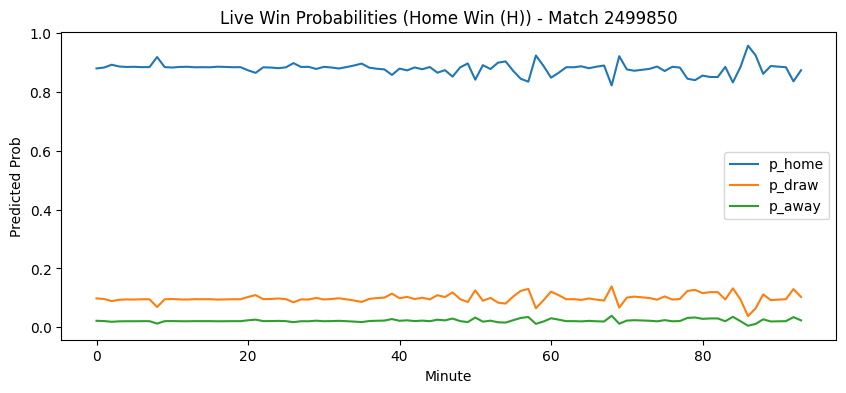

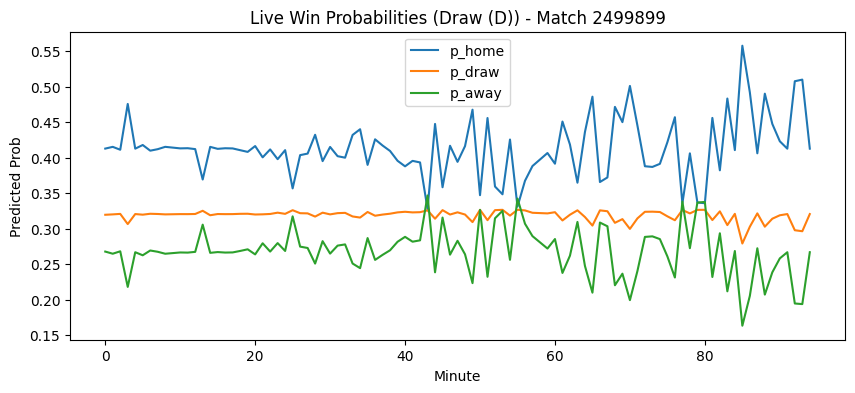

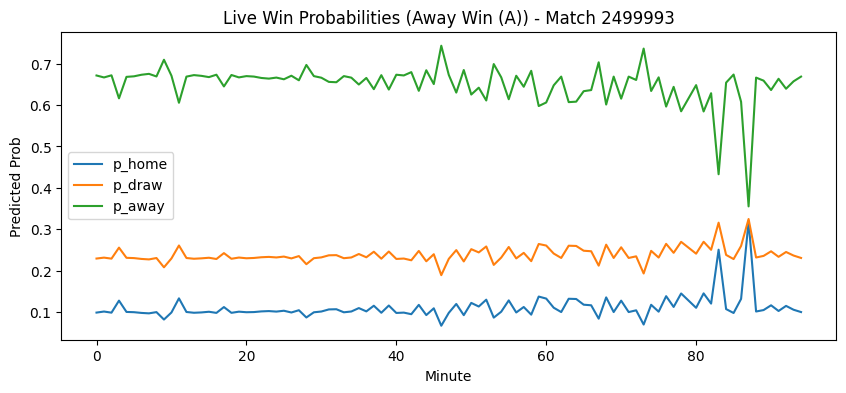

In [12]:
# ---------------------------
# 10. DEĞERLENDİRME: LogLoss ve Brier (per-minute)
# ---------------------------
# map y to one-hot for brier
y_onehot = np.zeros((N,3))
y_onehot[np.arange(N), y] = 1

# logloss: need predicted probs clipped
eps = 1e-12
pl = np.clip(probs_mean, eps, 1-eps)

# compute multiclass logloss per minute
logloss_per_min = -np.sum(y_onehot * np.log(pl), axis=1)
print("Average per-minute logloss:", logloss_per_min.mean())

# Brier per minute (multiclass) = sum (p_k - o_k)^2
brier_per_min = np.sum((pl - y_onehot)**2, axis=1)
print("Average per-minute Brier score (multiclass):", brier_per_min.mean())


# ---------------------------
# 11. RANDOM MATCH SELECTION
# ---------------------------

# random 1 home-win, 1 draw, 1 away-win match
home_matches = merged[merged["match_result"] == "H"][match_col].unique()
draw_matches = merged[merged["match_result"] == "D"][match_col].unique()
away_matches = merged[merged["match_result"] == "A"][match_col].unique()

# random selections (safely)
import numpy as np
rng = np.random.default_rng()

example_H = rng.choice(home_matches) if len(home_matches)>0 else None
example_D = rng.choice(draw_matches) if len(draw_matches)>0 else None
example_A = rng.choice(away_matches) if len(away_matches)>0 else None

print("Random H match:", example_H)
print("Random D match:", example_D)
print("Random A match:", example_A)


# ---------------------------
# 12. Plot function
# ---------------------------

def plot_match(match_id, title_label):
    m_df = merged[merged[match_col] == match_id].sort_values("minute")
    plt.figure(figsize=(10,4))
    plt.plot(m_df["minute"], m_df["p_home"], label="p_home")
    plt.plot(m_df["minute"], m_df["p_draw"], label="p_draw")
    plt.plot(m_df["minute"], m_df["p_away"], label="p_away")
    plt.xlabel("Minute")
    plt.ylabel("Predicted Prob")
    plt.title(f"Live Win Probabilities ({title_label}) - Match {match_id}")
    plt.legend()
    plt.show()

# Plot each if available
if example_H:
    plot_match(example_H, "Home Win (H)")
if example_D:
    plot_match(example_D, "Draw (D)")
if example_A:
    plot_match(example_A, "Away Win (A)")
